# Homework 4 - Question 2

## Importing and cleaning

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import random
from numpy import array

# Machine Learning
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.metrics import silhouette_score
from scipy.stats import ttest_ind

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
df['skinColor'] = (df.rater1 + df.rater2) /2
df = df[df.skinColor.notnull()]
df_referee = df[['playerShort','refNum','refCountry','Alpha_3','meanIAT','nIAT','seIAT','meanExp','nExp','seExp']]
df_referee.head()

,playerShort,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


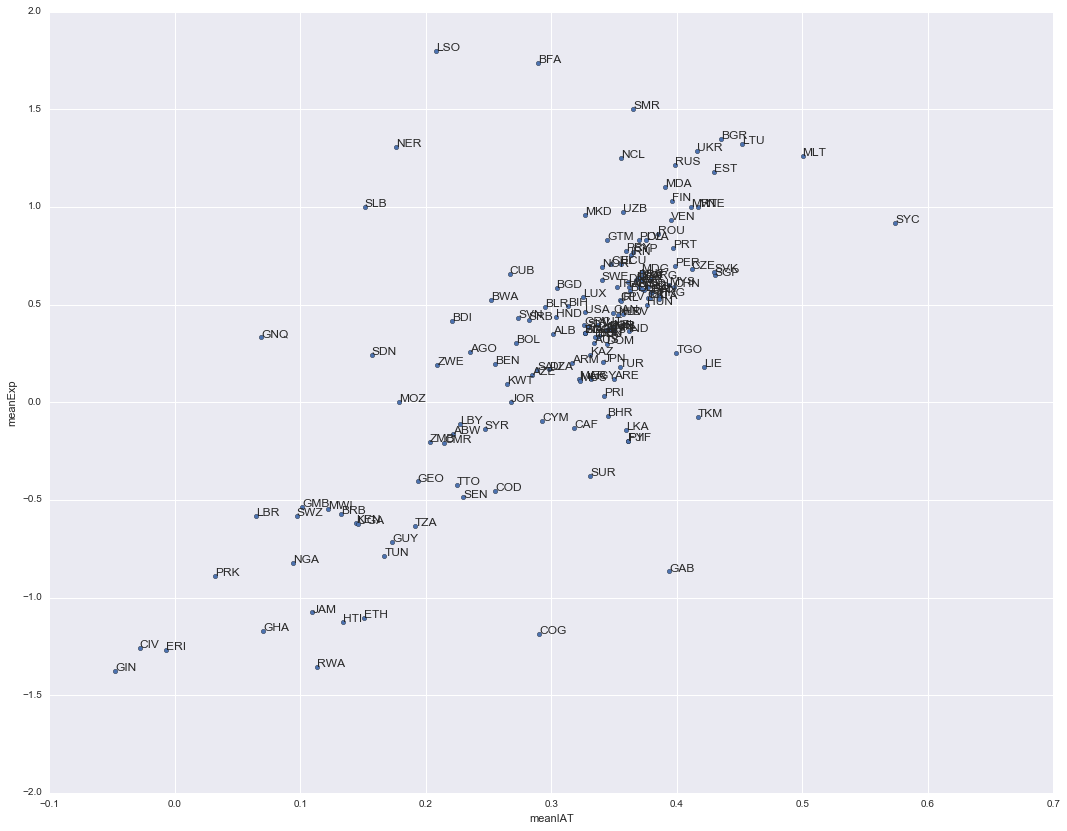

In [3]:
df_countries = df_referee.groupby('Alpha_3').first()[['meanIAT','meanExp']]

fig, ax = plt.subplots(figsize=(18, 14), dpi=400)

df_countries.plot(kind='scatter', x='meanIAT', y='meanExp', ax=ax)

for k, v in df_countries.iterrows():
    ax.annotate(k, v)

fig.canvas.draw()

## Aggregating players data and computing features

In [4]:
def weighted(df):
    for column in ['victories','defeats','ties','goals','yellowCards','yellowReds','redCards']:
        df[column+'IAT'] = df[column] * df['meanIAT']
        df[column+'Exp'] = df[column] * df['meanExp']
    for column in []:#['victories','defeats','ties','goals','yellowCards','yellowReds','redCards']:
        df.drop(column, axis=1, inplace=True)
    return df

df_players_weighted = weighted(
    df[
        ['skinColor','playerShort','games','victories','defeats','ties','goals','yellowCards','yellowReds','redCards','meanIAT','meanExp']
    ].copy()
)

df_players_weighted.head()


,skinColor,playerShort,games,victories,defeats,ties,goals,yellowCards,yellowReds,redCards,...,tiesIAT,tiesExp,goalsIAT,goalsExp,yellowCardsIAT,yellowCardsExp,yellowRedsIAT,yellowRedsExp,redCardsIAT,redCardsExp
0,0.375,lucas-wilchez,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.750,john-utaka,1,0,1,0,0,1,0,0,...,0.0,-0.0,0.0,-0.0,0.203375,-0.204082,0.0,-0.0,0.0,-0.0
5,0.125,aaron-hughes,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.125,aleksandar-kolarov,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
7,1.000,alexander-tettey,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [5]:
df_players_grouped = df_players_weighted.groupby('playerShort')

df_players_color = df_players_grouped.first().pop('skinColor')

df_players_color.head()

playerShort
aaron-hughes              0.125
aaron-hunt                0.125
aaron-lennon              0.250
aaron-ramsey              0.000
abdelhamid-el-kaoutari    0.250
Name: skinColor, dtype: float64

In [6]:
df_players = df_players_grouped.sum().drop('skinColor',axis=1)
df_players.drop(['meanIAT','meanExp'],axis=1,inplace=True)
df_players = df_players.div(df_players.games, axis='index')
df_players.drop(['games'],axis=1,inplace=True)
df_players.head()

,victories,defeats,ties,goals,yellowCards,yellowReds,redCards,victoriesIAT,victoriesExp,defeatsIAT,...,tiesIAT,tiesExp,goalsIAT,goalsExp,yellowCardsIAT,yellowCardsExp,yellowRedsIAT,yellowRedsExp,redCardsIAT,redCardsExp
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.377676,0.348624,0.273700,0.013761,0.029052,0.000000,0.000000,0.125911,0.154877,0.116244,...,0.091040,0.108587,0.004606,0.005612,0.009817,0.012586,0.000000,0.000000,0.000000,0.000000
aaron-hunt,0.419643,0.363095,0.217262,0.184524,0.125000,0.000000,0.002976,0.143563,0.164324,0.123388,...,0.074486,0.083222,0.062454,0.066173,0.042781,0.048419,0.000000,0.000000,0.001002,0.001000
aaron-lennon,0.485437,0.279126,0.235437,0.075243,0.026699,0.000000,0.000000,0.162948,0.201414,0.091605,...,0.077836,0.095341,0.024752,0.027332,0.008864,0.010738,0.000000,0.000000,0.000000,0.000000
aaron-ramsey,0.576923,0.261538,0.161538,0.150000,0.119231,0.000000,0.003846,0.193189,0.243003,0.089673,...,0.053776,0.065965,0.051691,0.073244,0.040240,0.051198,0.000000,0.000000,0.001287,0.001293
abdelhamid-el-kaoutari,0.330645,0.346774,0.322581,0.008065,0.064516,0.032258,0.016129,0.109080,0.108069,0.116718,...,0.106084,0.099404,0.002699,0.002710,0.021593,0.021684,0.010943,0.011726,0.005398,0.005421


## Clustering of soccer players

In [7]:
features = array(df_players.values.tolist())

In [8]:
whitened = whiten(features)
book = array((random.choice(whitened),random.choice(whitened)))
(centroids,distortion) = kmeans(whitened,book)
(centroids,distortion)

(array([[ 4.50582687,  3.70136203,  4.33104725,  1.07578336,  1.35768446,
          0.31144262,  0.3977977 ,  4.35775277,  2.7882476 ,  3.55161284,
          2.36490049,  4.22775215,  2.76596005,  1.06267962,  0.96009322,
          1.27587149,  0.90321128,  0.29639093,  0.22334657,  0.39392237,
          0.36918863],
        [ 3.87660353,  4.1989896 ,  4.69455216,  0.59159741,  2.67133849,
          1.58524881,  1.11266863,  3.89406738,  2.91353652,  4.20357387,
          3.35044194,  4.77056221,  3.67568806,  0.60685897,  0.63878789,
          2.62167138,  2.21390345,  1.58998005,  1.52964498,  1.1409647 ,
          1.22673794]]), 3.6588884409615021)

In [9]:
(repartition, distances) = vq(obs=whitened, code_book=centroids)
(repartition[:10],distances[:10],len(repartition))

(array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0], dtype=int32),
 array([ 2.83036896,  1.46404677,  2.17627335,  3.0916422 ,  6.8084683 ,
         2.76307486,  4.12023005,  9.9679298 ,  4.88638051,  5.83150585]),
 1585)

## Measure of the cluster silhouette and black/white division 

### Silhouette

In [10]:
silhouette_score(whitened,repartition)

0.23327527876403273

### Black/White

In [11]:
def average(list):
    return(sum(list)/len(list))

player_color = df_players_color.tolist()
player_color0 = [player_color[index] for index in range(len(player_color)) if repartition[index]==0]
player_color1 = [player_color[index] for index in range(len(player_color)) if repartition[index]==1]

print('average color',average(player_color))
print('average color in cluster 0',average(player_color0),len(player_color0))
print('average color in cluster 1',average(player_color1),len(player_color1))

average color 0.289511041009
average color in cluster 0 0.281768558952 1145
average color in cluster 1 0.309659090909 440


In [12]:
ttest_ind(player_color0,player_color1)

Ttest_indResult(statistic=-1.7103830994700222, pvalue=0.087390995315250172)